### 0) Import packages for data extraction and exploratory analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import aic, bic


### 1.0) Data Extraction

In [2]:
#S&P 500 (stock prices)
sp500 = yf.download("^GSPC",start="2000-01-01")[["Close"]]
sp500 = sp500.rename(columns={"Close": "SP500"})

# 3-month T-Bill (^IRX on Yahoo gives yield in %)
t3m = yf.download("^IRX", start="2000-01-01")[["Close"]]
t3m = t3m.rename(columns={"Close": "TBILL_3M"})

# 10-year Treasury yield (^TNX also in %)
t10y = yf.download("^TNX", start="2000-01-01")[["Close"]]
t10y = t10y.rename(columns={"Close": "YIELD_10Y"})

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### 1.1) Basic Data Inspection

In [3]:
print(sp500.head(), t3m.head(), t10y.head())
print(sp500.tail(), t3m.tail(), t10y.tail())
print(sp500.describe(), t3m.describe(), t10y.describe())

Price             SP500
Ticker            ^GSPC
Date                   
2000-01-03  1455.219971
2000-01-04  1399.420044
2000-01-05  1402.109985
2000-01-06  1403.449951
2000-01-07  1441.469971 Empty DataFrame
Columns: [(TBILL_3M, ^IRX)]
Index: [] Price      YIELD_10Y
Ticker          ^TNX
Date                
2000-01-03     6.548
2000-01-04     6.485
2000-01-05     6.599
2000-01-06     6.549
2000-01-07     6.504
Price             SP500
Ticker            ^GSPC
Date                   
2025-11-28  6849.089844
2025-12-01  6812.629883
2025-12-02  6829.370117
2025-12-03  6849.720215
2025-12-04  6857.120117 Empty DataFrame
Columns: [(TBILL_3M, ^IRX)]
Index: [] Price      YIELD_10Y
Ticker          ^TNX
Date                
2025-12-01     4.096
2025-12-02     4.086
2025-12-03     4.057
2025-12-04     4.108
2025-12-05     4.141
Price         SP500
Ticker        ^GSPC
count   6521.000000
mean    2256.288290
std     1436.000832
min      676.530029
25%     1210.079956
50%     1522.969971
75%     2881

### 1.2) Resample to weekly frequence (last friday of each week), Merge DF, Drop NaNs and Describing

In [3]:
FREQ = "W-FRI"
sp500_w = sp500.resample(FREQ).last()
t3m_w   = t3m.resample(FREQ).last()
t10y_w  = t10y.resample(FREQ).last()

data = sp500_w.join([t3m_w, t10y_w], how="inner").dropna()
data.columns = ["S&P500", "YIELD_3M", "YIELD_10Y"]

print(data.describe())
#data.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/raw_dataset.csv")

            S&P500     YIELD_3M    YIELD_10Y
count  1353.000000  1353.000000  1353.000000
mean   2258.933556     1.864978     3.310003
std    1439.604625     1.929145     1.292482
min     683.380005    -0.058000     0.536000
25%    1214.349976     0.090000     2.232000
50%    1525.750000     1.192000     3.410000
75%    2885.570068     3.640000     4.285000
max    6857.120117     6.190000     6.781000


### 1.3) Data Visualization

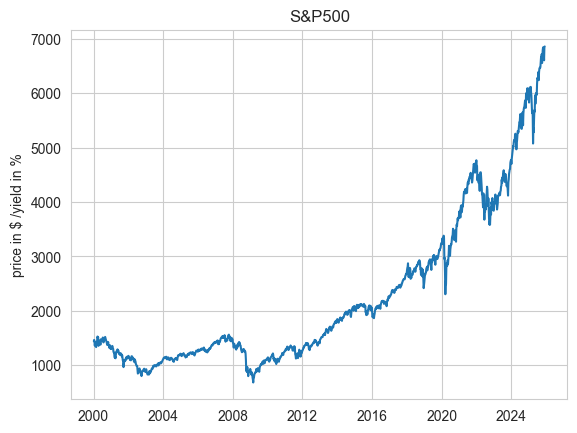

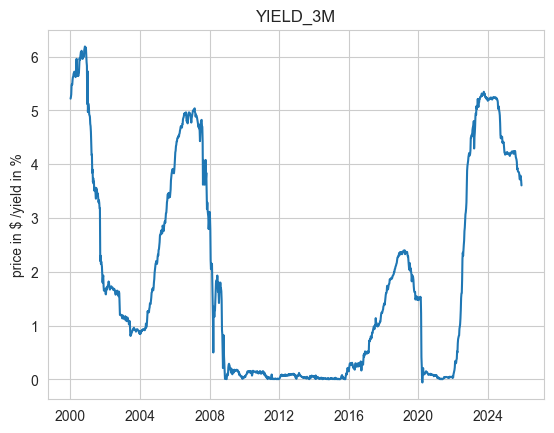

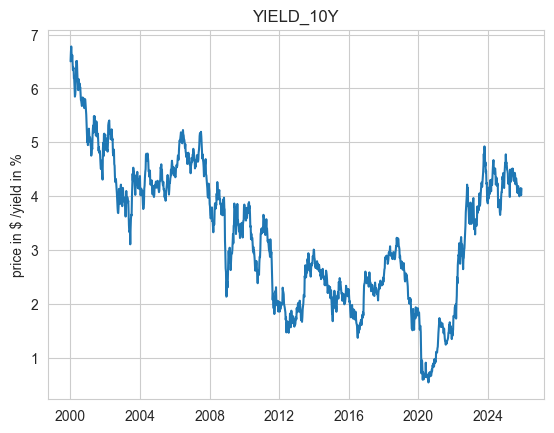

In [4]:
for column in data.columns:
    plt.plot(data[column], label=column)
    plt.title(column)
    plt.ylabel('price in $ /yield in %')
    plt.show()

### 1.4) Data transformation (ln differences for S&P 500 and simples differences for yields)

* S&P500: $r_t$ = $\log P_t$ - $\log P_{t-1}$
* Yields: $y_t$ = $y_t$ - $y_{t-1}$

In [5]:
data["spy_rt"] = np.log(data["S&P500"]).diff().dropna()
data["d_tbill"] = data["YIELD_3M"].diff().dropna()
data["d_tbond"] = data["YIELD_10Y"].diff().dropna()

data_chg = data[["spy_rt", "d_tbill", "d_tbond"]]
#data_chg.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/data_chg.csv")

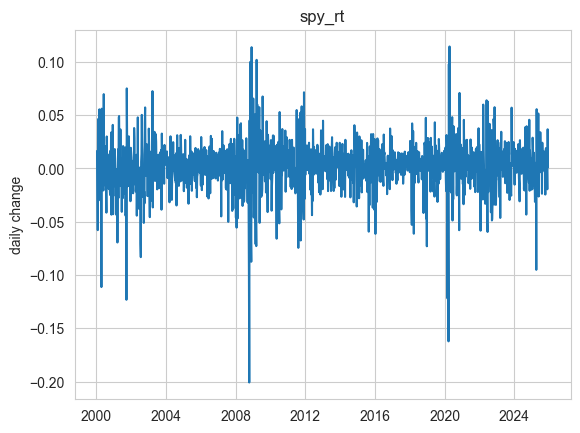

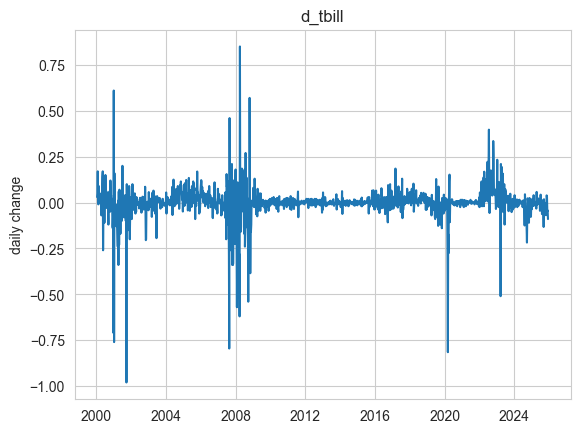

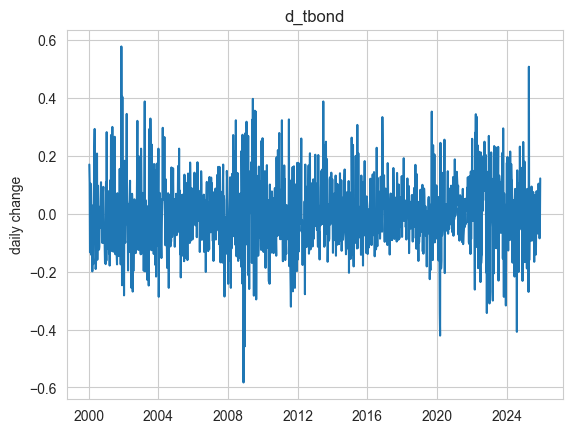

In [6]:
for column in data_chg.columns:
    plt.plot(data_chg[column], label=column, color=sns.color_palette()[0])
    plt.title(column)
    plt.ylabel('daily change')
    plt.show()

## Step 2: Testing for Stationarity (ADF)

In this step, we formally test whether our three transformed series are **stationary**, a key requirement before moving on to ARMA, GARCH, or VAR modeling.

The **Augmented Dickey–Fuller (ADF) test** is used to check for the presence of a **unit root** in each time series.


* $H_0$: Series has a unit root (non-stationary)

* $H_1$: Series is stationary $I(0)$


We apply the test to the following variables:

* ( $r_t$ = $\Delta$ $\log(P_t)$ ): S&P 500 log returns
* ( $\Delta$ $i_t^{(3M)}$ ): weekly change in the 3-month T-bill yield
* ( $\Delta$ $i_t^{(10Y)}$ ): weekly change in the 10-year bond yield

If the **p-value < 0.05**, we reject $H_0$ and conclude that the series is **stationary**.

This step ensures that our transformed variables are suitable for modeling with ARMA, GARCH, and VAR frameworks in the subsequent stages.



In [7]:
series_dict = {
    "r_t (Δ log P_t)": data_chg["spy_rt"].dropna(),
    "Δi_t (3M T-bill)": data_chg["d_tbill"].dropna(),
    "Δi_t (10Y bond)": data_chg["d_tbond"].dropna(),
}

def adf_summary(x):
    res = adfuller(x, autolag="AIC")
    stat, pval, lags, nobs, crit = res[0], res[1], res[2], res[3], res[4]
    return {
        "ADF_stat": stat,
        "p_value": pval,
        "lags_used": lags,
        "nobs": nobs,
        "cv_1%": crit.get("1%"),
        "cv_5%": crit.get("5%"),
        "cv_10%": crit.get("10%")
    }

results = pd.DataFrame({name: adf_summary(s) for name, s in series_dict.items()}).T
results = results[["ADF_stat","p_value","lags_used","nobs","cv_1%","cv_5%","cv_10%"]]


print("\nAugmented Dickey–Fuller (ADF) stationarity tests")
print("(H0: unit root; reject H0 ⇒ stationary / I(0))\n")
print(results.round(4))

#results.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/results.csv")



Augmented Dickey–Fuller (ADF) stationarity tests
(H0: unit root; reject H0 ⇒ stationary / I(0))

                  ADF_stat  p_value  lags_used    nobs   cv_1%   cv_5%  cv_10%
r_t (Δ log P_t)   -19.8008   0.0000        3.0  1348.0 -3.4352 -2.8637 -2.5679
Δi_t (3M T-bill)   -4.6728   0.0001       23.0  1328.0 -3.4353 -2.8637 -2.5679
Δi_t (10Y bond)   -16.8229   0.0000        3.0  1348.0 -3.4352 -2.8637 -2.5679


## Step 2.2: Ploting ACF and PACF for Log returns of S&P 500

- as we can see there is no significant autocorrelation in any lags

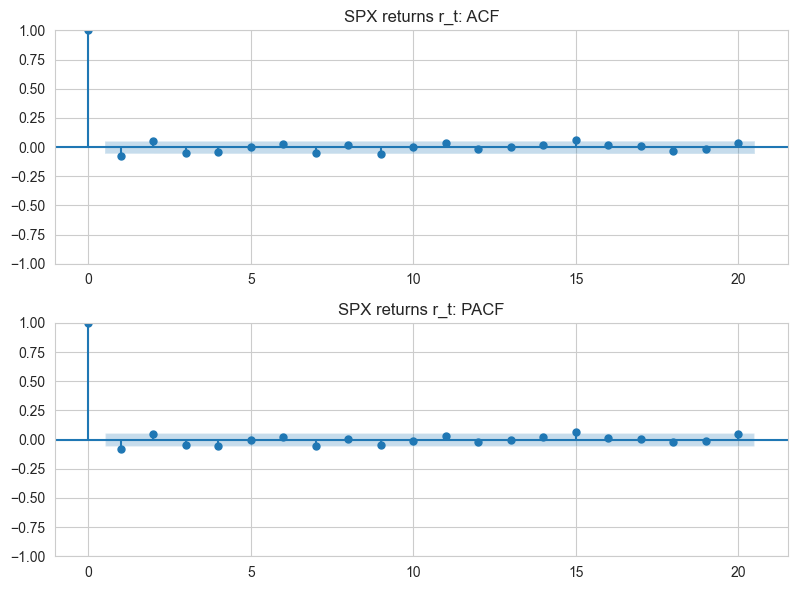

In [8]:
r_spx = data["spy_rt"]
r_spx = pd.to_numeric(r_spx, errors="coerce").dropna()

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(r_spx.values, lags=20, ax=ax[0])
ax[0].set_title("SPX returns r_t: ACF")
plot_pacf(r_spx.values, lags=20, method="ywm", ax=ax[1])
ax[1].set_title("SPX returns r_t: PACF")
plt.tight_layout(); plt.show()

## Step 3: Modeling Short-Run Dynamics with ARMA

We now model the short-term behavior of the **S&P 500 log returns** ( $r_t$ = $\Delta$ $\log P_t$ ) using an **Autoregressive Moving Average (ARMA)** model.

Formally:

$$
r_t = \mu + \sum_{i=1}^{p} \phi_i r_{t-i} + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j} + \varepsilon_t
$$

where:

* $\phi_i$ are the **autoregressive coefficients** capturing momentum or mean reversion,
* $\theta_j$ are the **moving average coefficients** capturing shock persistence, and
* $\varepsilon_t$ is a white-noise innovation with  $E$($\varepsilon_t$)=0  and $Var$($\varepsilon_t$)=$\sigma^2$.

The orders (p,q) are identified by minimizing the **Akaike Information Criterion (AIC)**, following the same procedure used in the course notes.

Once the best ARMA specification is selected, we will later analyze its residuals to model conditional volatility using **GARCH**.


In [9]:
y = data_chg["spy_rt"].dropna()

# Define search grid for p and q
pq_grid = [(p, q) for p in range(0, 4) for q in range(0, 4) if not (p == 0 and q == 0)]

best_ic = np.inf
best_order = None
best_res = None

for p, q in pq_grid:
    try:
        model = ARIMA(y, order=(p, 0, q))
        res = model.fit(method_kwargs={"warn_convergence": False})
        ic = res.aic
        print(f"(p={p}, q={q})  AIC={ic:.2f}")
        if ic < best_ic:
            best_ic = ic
            best_order = (p, q)
            best_res = res
    except Exception:
        continue

print(f"\nBest ARMA order by AIC: p={best_order[0]}, q={best_order[1]} (AIC={best_ic:.2f})")
print(best_res.summary())

#best_res.summary().to_csv("/Users/eduardo/Desktop/FinancialEconometrics/best_model_summary.csv")


(p=0, q=1)  AIC=-6155.64
(p=0, q=2)  AIC=-6156.63
(p=0, q=3)  AIC=-6158.97
(p=1, q=0)  AIC=-6156.34
(p=1, q=1)  AIC=-6156.97
(p=1, q=2)  AIC=-6155.43
(p=1, q=3)  AIC=-6158.34
(p=2, q=0)  AIC=-6157.31
(p=2, q=1)  AIC=-6153.46
(p=2, q=2)  AIC=-6153.42
(p=2, q=3)  AIC=-6157.68
(p=3, q=0)  AIC=-6157.78
(p=3, q=1)  AIC=-6155.98
(p=3, q=2)  AIC=-6157.75
(p=3, q=3)  AIC=-6155.22

Best ARMA order by AIC: p=0, q=3 (AIC=-6158.97)
                               SARIMAX Results                                
Dep. Variable:                 spy_rt   No. Observations:                 1352
Model:                 ARIMA(0, 0, 3)   Log Likelihood                3084.486
Date:                Fri, 05 Dec 2025   AIC                          -6158.972
Time:                        19:52:50   BIC                          -6132.925
Sample:                    01-14-2000   HQIC                         -6149.218
                         - 12-05-2025                                         
Covariance Type:       

## Step 4: Modeling Conditional Volatility with GARCH(1,1)

We now model the **time-varying volatility** of the S&P 500 returns using a **GARCH(1,1)** specification, as the residuals from the ARMA(0,3) model exhibit non-constant variance.

Formally:

$$
\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$

where:

* $\alpha$: measures the short-run impact of shocks on volatility, and
* $\beta$:  captures volatility persistence.

This step captures **volatility clustering**, a key feature of financial time series, where large movements in returns tend to be followed by periods of high volatility.


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2943.56
Distribution:                  Normal   AIC:                           5893.12
Method:            Maximum Likelihood   BIC:                           5908.75
                                        No. Observations:                 1352
Date:                Fri, Dec 05 2025   Df Residuals:                     1352
Time:                        19:53:31   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3499  9.193e-02      3.806  1.412e-04 [  0.170,  0.53

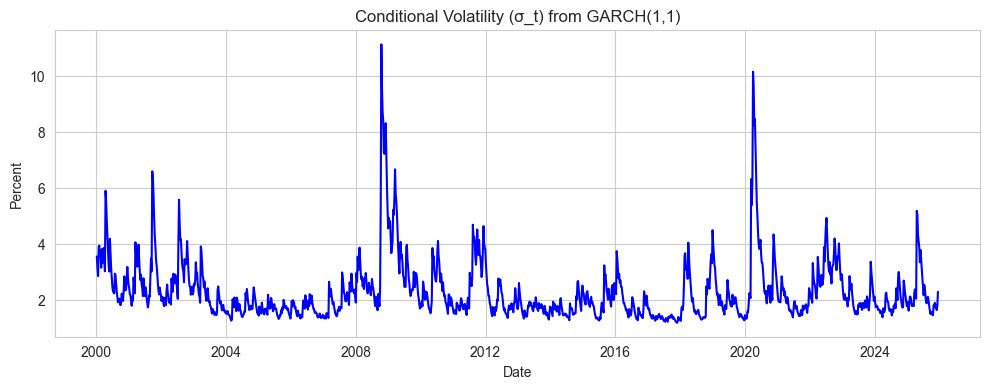

In [10]:
# Residuals from best ARMA(0,3)
residuals = best_res.resid.dropna()

# Fit GARCH(1,1) on returns (mean zero specification)
am = arch_model(residuals * 100, vol='GARCH', p=1, q=1, mean='Zero')
garch_res = am.fit(disp='off')

print(garch_res.summary())

# Plot conditional volatility
plt.figure(figsize=(10, 4))
plt.plot(garch_res.conditional_volatility, color='blue')
plt.title('Conditional Volatility (σ_t) from GARCH(1,1)')
plt.ylabel('Percent')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

#garch_res.summary().to_csv("/Users/eduardo/Desktop/FinancialEconometrics/garchsummary.csv")


### Step 5 — VAR between $r_t$ and $\Delta$ $i_t^{(10Y)}$

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -11.65     -11.64*   8.735e-06     -11.65*
1      -11.65      -11.63   8.708e-06      -11.64
2      -11.65      -11.61   8.703e-06      -11.64
3      -11.65      -11.60   8.719e-06      -11.63
4      -11.65      -11.58   8.709e-06      -11.63
5      -11.65      -11.56   8.740e-06      -11.62
6      -11.65      -11.55   8.691e-06      -11.62
7     -11.66*      -11.54  8.667e-06*      -11.61
8      -11.65      -11.52   8.687e-06      -11.60
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Dec, 2025
Time:                     19:53:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.5376
Nobs:                     1345.00    

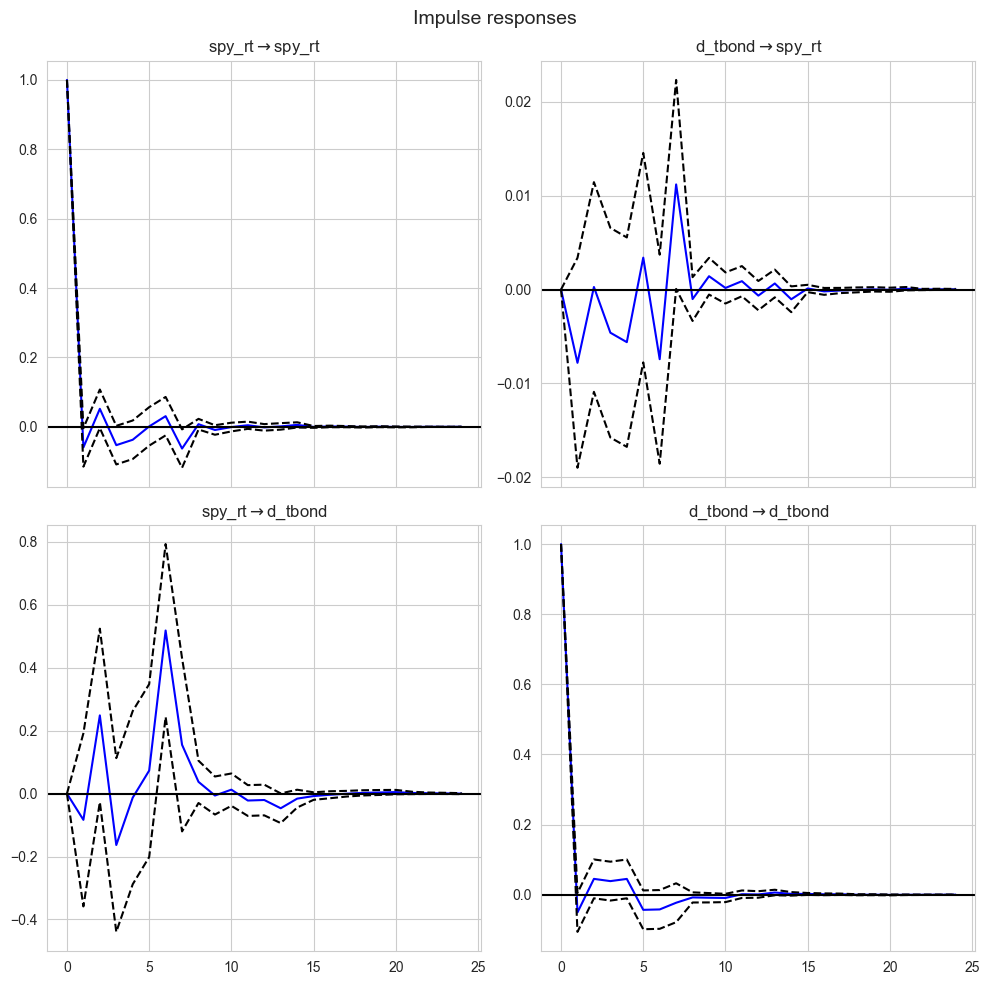


H0: Δi_t (10Y) does NOT Granger-cause r_t
Granger causality F-test. H_0: d_tbond does not Granger-cause spy_rt. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.250          2.013   0.271 (7, 2660)
-----------------------------------------------

H0: r_t does NOT Granger-cause Δi_t (10Y)
Granger causality F-test. H_0: spy_rt does not Granger-cause d_tbond. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         2.907          2.013   0.005 (7, 2660)
-----------------------------------------------


In [11]:
# Prepare data for VAR
Z = data_chg[["spy_rt", "d_tbond"]].dropna()

# Select optimal lag order
var_model = VAR(Z)
lag_selection = var_model.select_order(maxlags=8)
print(lag_selection.summary())

# Fit VAR(p) using AIC-selected lag
p_opt = lag_selection.aic
var_res = var_model.fit(p_opt)
print(var_res.summary())

# Plot Impulse Response Functions (24 weeks or 0.5 year ahead)
irf = var_res.irf(24)
irf.plot(orth=False)
plt.tight_layout()
plt.show()

# Granger causality tests
print("\nH0: Δi_t (10Y) does NOT Granger-cause r_t")
print(var_res.test_causality(caused="spy_rt", causing=["d_tbond"], kind="f").summary())

print("\nH0: r_t does NOT Granger-cause Δi_t (10Y)")
print(var_res.test_causality(caused="d_tbond", causing=["spy_rt"], kind="f").summary())

#var_res.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/var_summary.csv")


### Step 6 — Save VAR(7) output and key statistics

In [12]:
stats = {
    "aic": [var_res.aic],
    "bic": [var_res.bic],
    "hqic": [getattr(var_res, "hqic", None)],
    "nobs": [var_res.nobs],
    "selected_lags": [var_res.k_ar]
}

stats_df = pd.DataFrame(stats)
#stats_df.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/var_model_stats.csv", index=False)
params_df = pd.DataFrame(var_res.params)
#params_df.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/var_model_params.csv", index=False)


### Step 8 — Orthogonalized IRFs with COVID & Rate Hike Dummies


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -11.64     -11.62*   8.766e-06     -11.64*
1      -11.65      -11.61   8.736e-06      -11.63
2      -11.65      -11.59   8.734e-06      -11.63
3      -11.65      -11.58   8.751e-06      -11.62
4      -11.65      -11.56   8.742e-06      -11.62
5      -11.64      -11.54   8.772e-06      -11.61
6      -11.65      -11.53   8.723e-06      -11.61
7     -11.65*      -11.52  8.698e-06*      -11.60
8      -11.65      -11.50   8.718e-06      -11.59
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Dec, 2025
Time:                     19:53:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.5185
Nobs:                     1345.00    

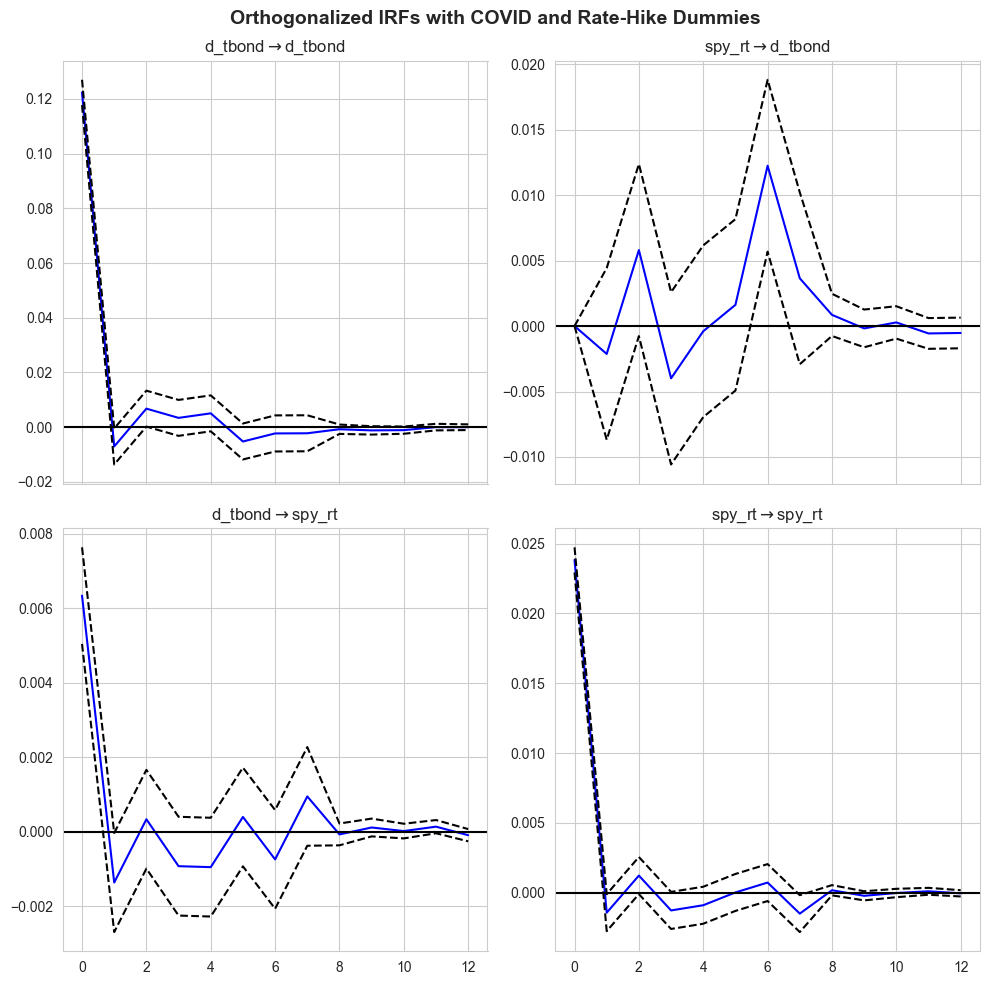

Saved orthogonalized IRFs and model parameters with exogenous dummies.


In [13]:
# Prepare data
Z = data_chg[["d_tbond", "spy_rt"]].dropna()  # order: rates first, returns second

# Create exogenous dummies
exog = pd.DataFrame(index=Z.index)
exog["covid"] = ((exog.index >= "2020-03-01") & (exog.index <= "2020-06-30")).astype(int)
exog["rate_hike"] = (exog.index >= "2022-03-01").astype(int)

# Fit VAR with exogenous dummies
var_ex = VAR(endog=Z, exog=exog)
lag_selection = var_ex.select_order(maxlags=8)
print(lag_selection.summary())

p_opt = lag_selection.aic
var_ex_res = var_ex.fit(p_opt)
print(var_ex_res.summary())

# Orthogonalized IRFs (Cholesky, order: rates → returns)
irf_ex = var_ex_res.irf(12)
fig = irf_ex.plot(orth=True)
plt.suptitle("Orthogonalized IRFs with COVID and Rate-Hike Dummies", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

# Save IRF results and parameters
os.makedirs("/Users/eduardo/Desktop/FinancialEconometrics", exist_ok=True)
irf_ex_df = irf_ex.irfs.reshape(irf_ex.irfs.shape[0], -1)
cols = [f"response_{i}_{j}" for i in Z.columns for j in Z.columns]
pd.DataFrame(irf_ex_df, columns=cols).to_csv("/Users/eduardo/Desktop/FinancialEconometrics/irf_exog_results.csv", index=False)
var_ex_res.params.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/var_exog_params.csv")

print("Saved orthogonalized IRFs and model parameters with exogenous dummies.")